In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import os
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from functools import partial
from copy import deepcopy

path = os.path.dirname(os.getcwd())
os.chdir(path)

from src.BayesIMP import *
from src.causalKLGP import *
from src.kernels import *
from src.GP_utils import *
from src.training_utils import *
from src.kernel_utils import *
from src.dgps import *

### Drawing data

In [2]:
# DGP set up
torch.random.manual_seed(1)
d = 5
train_samples = 100
test_samples = 1000
noise_variance = 0.5
input_distribution = torch.distributions.uniform.Uniform(0,1)
mc_samples_EY = 10**4

# PLotting settings
z_val = 1.96

/tmp/ipykernel_291944/2512539941.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724888750493/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  VdoA = (f_x(doA,coefs_v)).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T


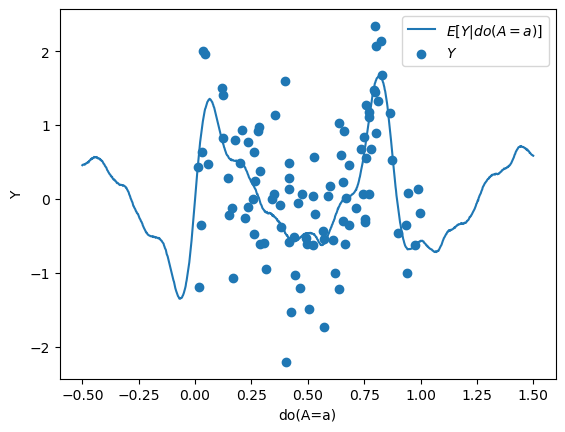

In [3]:
# Dataset generation and plotting E[Y|do(A)]
torch.random.manual_seed(1)
coefs_v = 10*torch.linspace(1,4,d).view(1,d)
coefs_y = 1/torch.linspace(1,d,d).view(d,)

A = input_distribution.sample((train_samples,1))
doA = torch.linspace(-0.5,1.5,test_samples).view(test_samples,1)
fv = f_x(A,coefs_v)#*A
noise_distribution = Normal(0,(noise_variance*fv.var(0))**0.5)
V = fv+noise_distribution.sample((train_samples,))
fy = f_y(V,coefs_y)#*V[:,0]
Y = Normal(fy,(noise_variance*fy.var())**0.5).sample()

# Grid-points to approximate true E[Y|do(A)]
VdoA = (f_x(doA,coefs_v)).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T
EYdoA = (f_y(VdoA.T,coefs_y)).mean(1).view(test_samples,1)
YdoA = Normal(f_y(VdoA[...,0].T,coefs_y),(noise_variance*fy.var())**0.5).sample()

# Plot
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,Y, label = r"$Y$")
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.legend()
plt.show()

### Running BayesIMP

In [4]:
nulist = 2**torch.linspace(-2,2,3)*(V.var()**0.5)
print(nulist)


"""
Training P(Y|V)
"""
learn_rate = 0.1
n_iter = 500
n = train_samples

Kernels_V = []
Noise_Y =  []
Loss_Y = []

for k in range(len(nulist)):
    nu = torch.tensor([nulist[k]]).requires_grad_(False)
    
    # Initialisation
    kernel_V_scale = torch.tensor([1.0], requires_grad = True)
    kernel_V_ls = torch.tensor([d**0.5*1.0]).repeat(d).requires_grad_(True)
    noise_Y = torch.tensor([-2.0],requires_grad = True).float()
    kernel_V = NuclearGaussianKernel(lengthscale = kernel_V_ls,
                                     scale = kernel_V_scale,
                                     sigma = nu)
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_V.lengthscale,
                                  kernel_V.scale,
                                  kernel_V.sigma,
                                  noise_Y], lr=learn_rate)
    Losses = torch.zeros(n_iter)

    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -GPML(Y, V, kernel_V, torch.exp(noise_Y))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
                print("iter {0} loss: ".format(i), Losses[i])

    # Storing
    Kernels_V.append(kernel_V)
    Noise_Y.append(torch.exp(noise_Y))
    Loss_Y.append(Losses[-1])

tensor([0.2249, 0.8994, 3.5976])
iter 0 loss:  tensor(238.0298)
iter 100 loss:  tensor(95.5114)
iter 200 loss:  tensor(94.9053)
iter 300 loss:  tensor(94.7273)
iter 400 loss:  tensor(94.6568)
iter 0 loss:  tensor(152.7733)
iter 100 loss:  tensor(93.3643)
iter 200 loss:  tensor(93.2640)
iter 300 loss:  tensor(93.2431)
iter 400 loss:  tensor(93.2384)
iter 0 loss:  tensor(248.5623)
iter 100 loss:  tensor(92.7854)
iter 200 loss:  tensor(92.6338)
iter 300 loss:  tensor(92.5795)
iter 400 loss:  tensor(92.5482)


In [5]:
"""
Training P(V|A)
"""
learn_rate = 0.1
n_iter=500

Kernels_A = []
Noise_feat =  []
Loss_feat = []

for k in range(len(nulist)):
    nu = Kernels_V[k].sigma
    
    # Initialisation
    med_heur = median_heuristic(A)
    kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),
                              scale = torch.tensor([1.0], requires_grad = True))
    noise_feat = torch.tensor(-2.0, requires_grad = True)
    
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_A.scale,noise_feat], lr=learn_rate)
    Losses = torch.zeros(n_iter)
    
    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss =  -GPfeatureML(V, A, kernel_V, kernel_A, torch.exp(noise_feat))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
            print("iter {0} loss: ".format(i), Losses[i])
    
    # Storing
    Kernels_A.append(kernel_A)
    Noise_feat.append(torch.exp(noise_feat))     
    Loss_feat.append(Losses[-1])

/tmp/ipykernel_291944/3439485288.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),


iter 0 loss:  tensor(-38939.1836)
iter 100 loss:  tensor(-39007.6875)
iter 200 loss:  tensor(-39007.6914)
iter 300 loss:  tensor(-39007.6875)
iter 400 loss:  tensor(-39007.6875)
iter 0 loss:  tensor(-38939.1836)
iter 100 loss:  tensor(-39007.6875)
iter 200 loss:  tensor(-39007.6914)
iter 300 loss:  tensor(-39007.6875)
iter 400 loss:  tensor(-39007.6875)
iter 0 loss:  tensor(-38939.1836)
iter 100 loss:  tensor(-39007.6875)
iter 200 loss:  tensor(-39007.6914)
iter 300 loss:  tensor(-39007.6875)
iter 400 loss:  tensor(-39007.6875)


nu =  tensor(0.2249) negMLL(Y) =  tensor(94.6271)
nu =  tensor(0.8994) negMLL(Y) =  tensor(93.2376)
nu =  tensor(3.5976) negMLL(Y) =  tensor(92.5175)


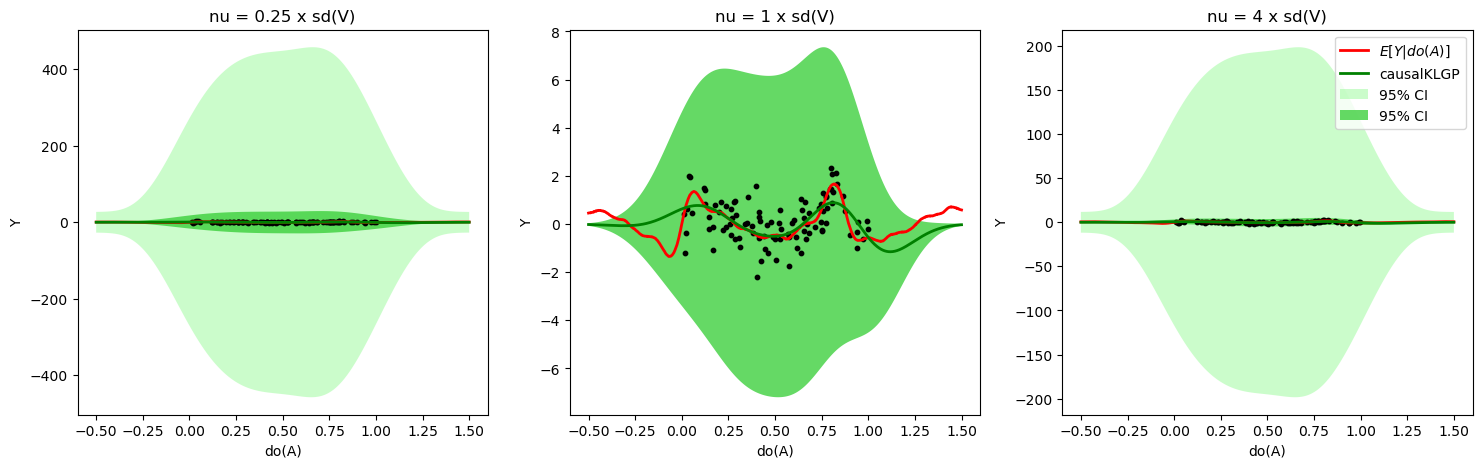

In [6]:
# Getting posterior moments and plotting results
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

BayesIMP_mu = []
BayesIMP_var = []
BayesIMP_var_noise = []


for k in range(len(nulist)):
    kernel_A = Kernels_A[k]
    kernel_V = Kernels_V[k]
    noise_Y = Noise_Y[k]
    noise_feat = Noise_feat[k]
    loss_y = Loss_Y[k]

    
    # getting post mean predictions
    Bayesimp = BayesIMP(kernel_A, kernel_V, [], noise_Y, noise_feat)
    Bayesimp_mu = Bayesimp.post_mean(Y, A, V, doA).detach()
    Bayesimp_var = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4).detach()
    Bayesimp_var_noise = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4, latent = False).detach()
    
     # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (Bayesimp_mu[indices]+z_val*torch.sqrt(torch.diag(Bayesimp_var[indices])))
    Lower = (Bayesimp_mu[indices]-z_val*torch.sqrt(torch.diag(Bayesimp_var[indices])))
    Upper_noise = (Bayesimp_mu[indices]+z_val*torch.sqrt(torch.diag(Bayesimp_var_noise[indices])))
    Lower_noise = (Bayesimp_mu[indices]-z_val*torch.sqrt(torch.diag(Bayesimp_var_noise[indices])))
    print("nu = ", nulist[k], "negMLL(Y) = ", loss_y)

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],Bayesimp_mu[indices], label = r"causalKLGP", color = "green", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "palegreen",alpha=0.5, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "limegreen",alpha=0.75, edgecolor='none', label = "95% CI")
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    axs[k].set_title("nu = " + str(2**(-2+2*k))+" x sd(V)")

    BayesIMP_mu.append(Bayesimp_mu)
    BayesIMP_var.append(Bayesimp_var)
    BayesIMP_var_noise.append(Bayesimp_var_noise)
    
plt.legend()
plt.show()
#fig.savefig("d={0}_Bayesimp".format(d), bbox_inches = "tight")

# causalKLGP

In [7]:
"""Initialising model"""
model = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.5,0.75,0.9,0.95])

Post_levels, Calibration_losses = model.calibrate(Y, V, A, nulist, niter = niter, levels = levels, learn_rate = learn_rate)
best_ind = torch.where(Calibration_losses == Calibration_losses.min())[0]
nu_best = nulist[best_ind]
print(Calibration_losses)

iter 0 P(Y|V) loss:  tensor(47.0432)
iter 100 P(Y|V) loss:  tensor(40.8874)
iter 200 P(Y|V) loss:  tensor(40.8746)
iter 300 P(Y|V) loss:  tensor(40.8744)
iter 400 P(Y|V) loss:  tensor(40.8743)
iter 0 P(V|A) loss:  tensor(51.2242)
iter 100 P(V|A) loss:  tensor(18.8458)
iter 200 P(V|A) loss:  tensor(18.8456)
iter 300 P(V|A) loss:  tensor(18.8456)
iter 400 P(V|A) loss:  tensor(18.8456)
tensor([0.3550, 0.3500, 0.3450, 0.2900, 0.2200, 0.0850, 0.0150, 0.0300, 0.0300,
        0.0300, 0.0300])


In [8]:
""" Training full model """
model.train(Y,A,V,niter,learn_rate)

iter 0 P(Y|V) loss:  tensor(101.6438)
iter 100 P(Y|V) loss:  tensor(86.9620)
iter 200 P(Y|V) loss:  tensor(86.8687)
iter 300 P(Y|V) loss:  tensor(86.8343)
iter 400 P(Y|V) loss:  tensor(86.8173)
iter 0 P(V|A) loss:  tensor(4.1097)
iter 100 P(V|A) loss:  tensor(-9.0587)
iter 200 P(V|A) loss:  tensor(-9.0591)
iter 300 P(V|A) loss:  tensor(-9.0592)
iter 400 P(V|A) loss:  tensor(-9.0591)


nu =  tensor(0.2249)
nu =  tensor(0.8994)
nu =  tensor(3.5976)


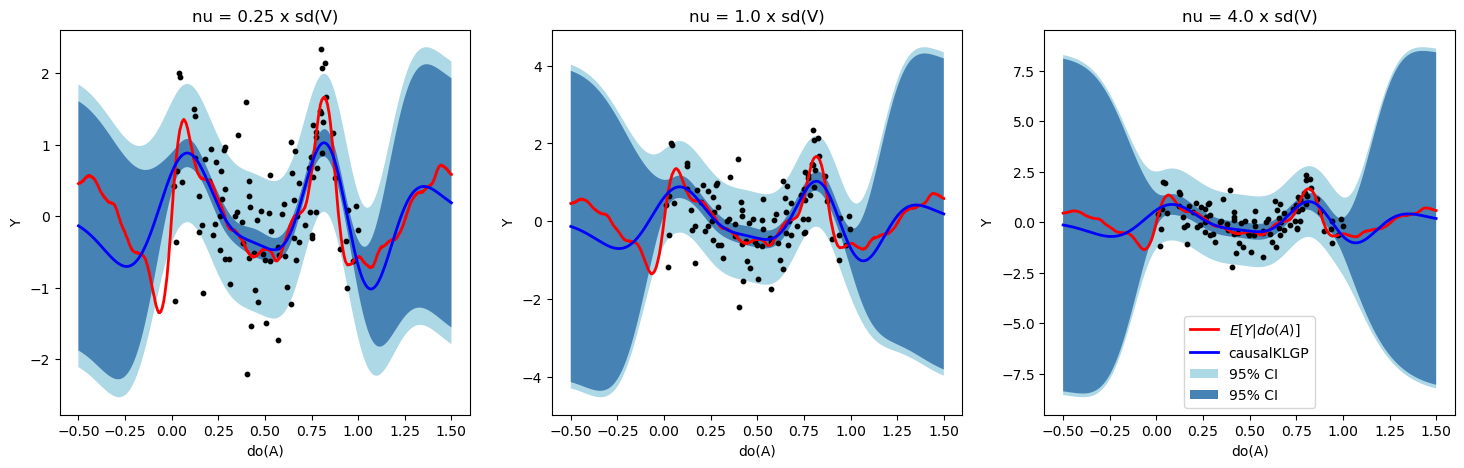

In [9]:
# Getting posterior moments and plotting results
power_list = torch.linspace(-2,2,3)
nulist = 2**power_list*(V.var()**0.5)

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

Causalklgp_mu = []
Causalklgp_var = []
Causalklgp_var_noise = []

for k in range(len(nulist)):
    
    # getting post mean predictions
    causalklgp = deepcopy(model)
    causalklgp_mu = causalklgp.post_mean(Y, A, V, doA).detach()
    causalklgp_var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach()
    causalklgp_var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach()
    
    # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (causalklgp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(causalklgp_var[indices])))
    Lower = (causalklgp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(causalklgp_var[indices])))
    Upper_noise = (causalklgp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(causalklgp_var_noise[indices])))
    Lower_noise = (causalklgp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(causalklgp_var_noise[indices])))
    print("nu = ", nulist[k])

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],causalklgp_mu[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    
    Causalklgp_mu.append(causalklgp_mu)
    Causalklgp_var.append(causalklgp_var.diag())
    Causalklgp_var_noise.append(causalklgp_var_noise.diag())

plt.legend()
plt.show()

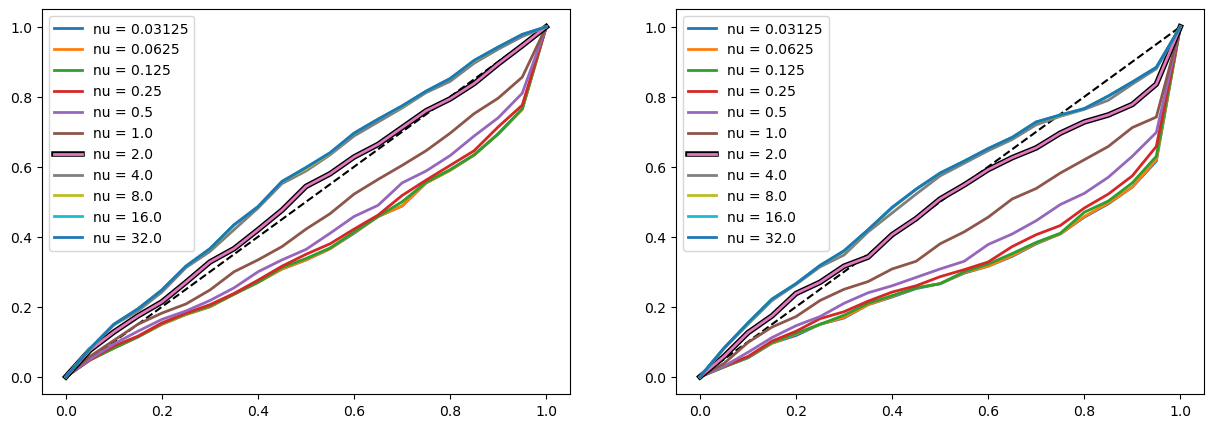

In [10]:
# Getting calibration plots
import matplotlib.patheffects as mpe
outline=mpe.withStroke(linewidth=4, foreground='black')

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)[:,None]
nulist = 2**torch.linspace(-5,5,11)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post mean predictions
    mean = causalklgp.post_mean(Y, A, V, doA).detach()
    var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach().diag()[:,None]
    var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach().diag()[:,None]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((YdoA[inds,None] - mean[inds]).abs() <= var_noise[inds]**0.5 @ z_quantiles.T).float().mean(0)
    posterior_fraction_y = ((EYdoA[inds] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}".format(nulist[k]), lw = 2, path_effects = [outline]*(best_ind ==k))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}".format(nulist[k]),lw = 2 , path_effects = [outline]*(best_ind ==k))
    axs[0].legend()
    axs[1].legend()

# Nystrom method

In [11]:
"""Initialising model"""
model_nystrom = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.5,0.75,0.9,0.95])

Post_levels, Calibration_losses = model_nystrom.calibrate(Y, V, A, nulist, niter = niter, levels = levels, learn_rate = learn_rate, 
                                                          nystrom = True, nystrom_features = 100, nystrom_samples = 10**3)
best_ind = torch.where(Calibration_losses == Calibration_losses.min())[0]
nu_best = nulist[best_ind]
print(Calibration_losses)

iter 0 P(Y|V) loss:  tensor(47.0432)
iter 100 P(Y|V) loss:  tensor(40.8874)
iter 200 P(Y|V) loss:  tensor(40.8746)
iter 300 P(Y|V) loss:  tensor(40.8744)
iter 400 P(Y|V) loss:  tensor(40.8743)
iter 0 P(V|A) loss:  tensor(51.2242)
iter 100 P(V|A) loss:  tensor(18.8458)
iter 200 P(V|A) loss:  tensor(18.8456)
iter 300 P(V|A) loss:  tensor(18.8456)
iter 400 P(V|A) loss:  tensor(18.8456)


RuntimeError: The size of tensor a (100) must match the size of tensor b (1000) at non-singleton dimension 1

In [13]:
# Getting Nystrom Samples and plotting
EYdoA_sample,YdoA_sample = causalklgp.nystrom_sample(Y,V,A,doA, reg = 1e-4, features = 100, samples = 200)

In [ ]:
quantile = 0.95
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
plt.plot(doA[indices],EYdoA_sample.mean(0)[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
plt.fill_between(doA[indices][:,0],YdoA_sample.quantile(1-(1-quantile)/2,0),YdoA_sample.quantile((1-quantile)/2,0), color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
plt.fill_between(doA[indices][:,0],EYdoA_sample.quantile(1-(1-quantile)/2,0),EYdoA_sample.quantile((1-quantile)/2,0), color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
#plt.scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
plt.scatter(A,Y, s = 10, color = "black")
plt.xlabel("do(A)")
plt.ylabel("Y")
plt.ylim(-5,5)

In [ ]:
# Calibrating Nystrom 
samples = 10**3
levels = torch.tensor([0.5,0.75,0.9,0.95])
upper_quantiles = 1-(1-levels)/2
lower_quantiles = (1-levels)/2
u = (upper_quantiles*samples).int()
l = (lower_quantiles*samples).int()
Y_u = YdoA_sample.sort(0)[0][u]
Y_l = YdoA_sample.sort(0)[0][l]
post_levels = ((Y_u>=YdoA)*(Y_l<=YdoA)).float().mean(1)
print(post_levels)